In [1]:
import os
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.patches import Patch
from picconfig import survpath, phecodespath, phedefpath, temppath, numericpath
raw={}
for i in os.listdir(survpath):
    if i.endswith('.npy'):
        if not i.endswith('lab.npy'):
            if not i.endswith('out.npy'):
                name = i.split('_')[0]
                if name.endswith('0'):
                    raw[name]=np.load(survpath+i)

In [2]:
raw.keys()

dict_keys(['400', '130', '610', '200', '410', '230', '430', '620', '100', '630', '420', '500', '510', '300', '530', '220', '600', '120', '310', '210', '320', '520', '330', '110'])

In [3]:
best_perf={}
for i in range(1,7):
    for j in range(4):
        for k in range(1):
            temp=0
            mx=''
            for name in sorted(raw.keys()):
                if name[:3]==f'{i}{j}{k}':
                    if np.nanmean(raw[name])>=temp:
                        mx=name
                        temp=np.nanmean(raw[name])
            best_perf[f'{i}{j}{k}']=mx

In [4]:
best_perf

{'100': '100',
 '110': '110',
 '120': '120',
 '130': '130',
 '200': '200',
 '210': '210',
 '220': '220',
 '230': '230',
 '300': '300',
 '310': '310',
 '320': '320',
 '330': '330',
 '400': '400',
 '410': '410',
 '420': '420',
 '430': '430',
 '500': '500',
 '510': '510',
 '520': '520',
 '530': '530',
 '600': '600',
 '610': '610',
 '620': '620',
 '630': '630'}

In [5]:
cat5data={}
for k,v in best_perf.items():
    if v=='':
        continue
    if k[2]=='0':
        cat5data[k[:2]]=raw[v]
reordered={}
order=np.array([0, 2, 3, 1],dtype=str)
for i in range(len(order)):
    for j in range(1,7):
        reordered[f'{j}{i}']=cat5data[f'{j}{order[i]}']
cat5data=reordered

In [6]:
for k,v in cat5data.items():
    if len(v)!=1560:
        v+=[np.nan]*(1560-len(v))
    print(k,len(v))

10 1560
20 1560
30 1560
40 1560
50 1560
60 1560
11 1560
21 1560
31 1560
41 1560
51 1560
61 1560
12 1560
22 1560
32 1560
42 1560
52 1560
62 1560
13 1560
23 1560
33 1560
43 1560
53 1560
63 1560


In [7]:
phecodes_def = pd.read_csv(phedefpath)[['phecode', 'phenotype']]
phecodes = pd.read_csv(phecodespath)['Phecode']
phenotypes = [(phecodes_def['phenotype'][x==phecodes_def['phecode']]).item() for x in phecodes]

In [8]:
modelnames=['CoxPH','POPDxSurv','MITHSurv','DeepSurv']
def forminput(data,length=1568):
    div1=[]
    div2=[]
    length=data[list(data.keys())[0]].shape[0]
    for i in data.keys():
        t,s=i
        div1.append(t)
        div2.append(s)
    div1=np.unique(div1)
    div2=np.unique(div2)
    seqhue=[]
    seqgroup=[]
    seqdata=[]
    seqphecode = []
    seqindex = []
    for i in div1:
        for j in div2:
            try:
                seqdata+=list(data[i+j])
                seqhue+=[i]*length
                seqgroup+=[j]*length
                seqphecode += phenotypes
                seqindex += list(range(length))
            except:
                print(i+j)
    return  pd.DataFrame({'index': seqindex, 'phenotype': seqphecode,'group':seqgroup,'hue':seqhue,'data':seqdata})
ipt=forminput(cat5data)

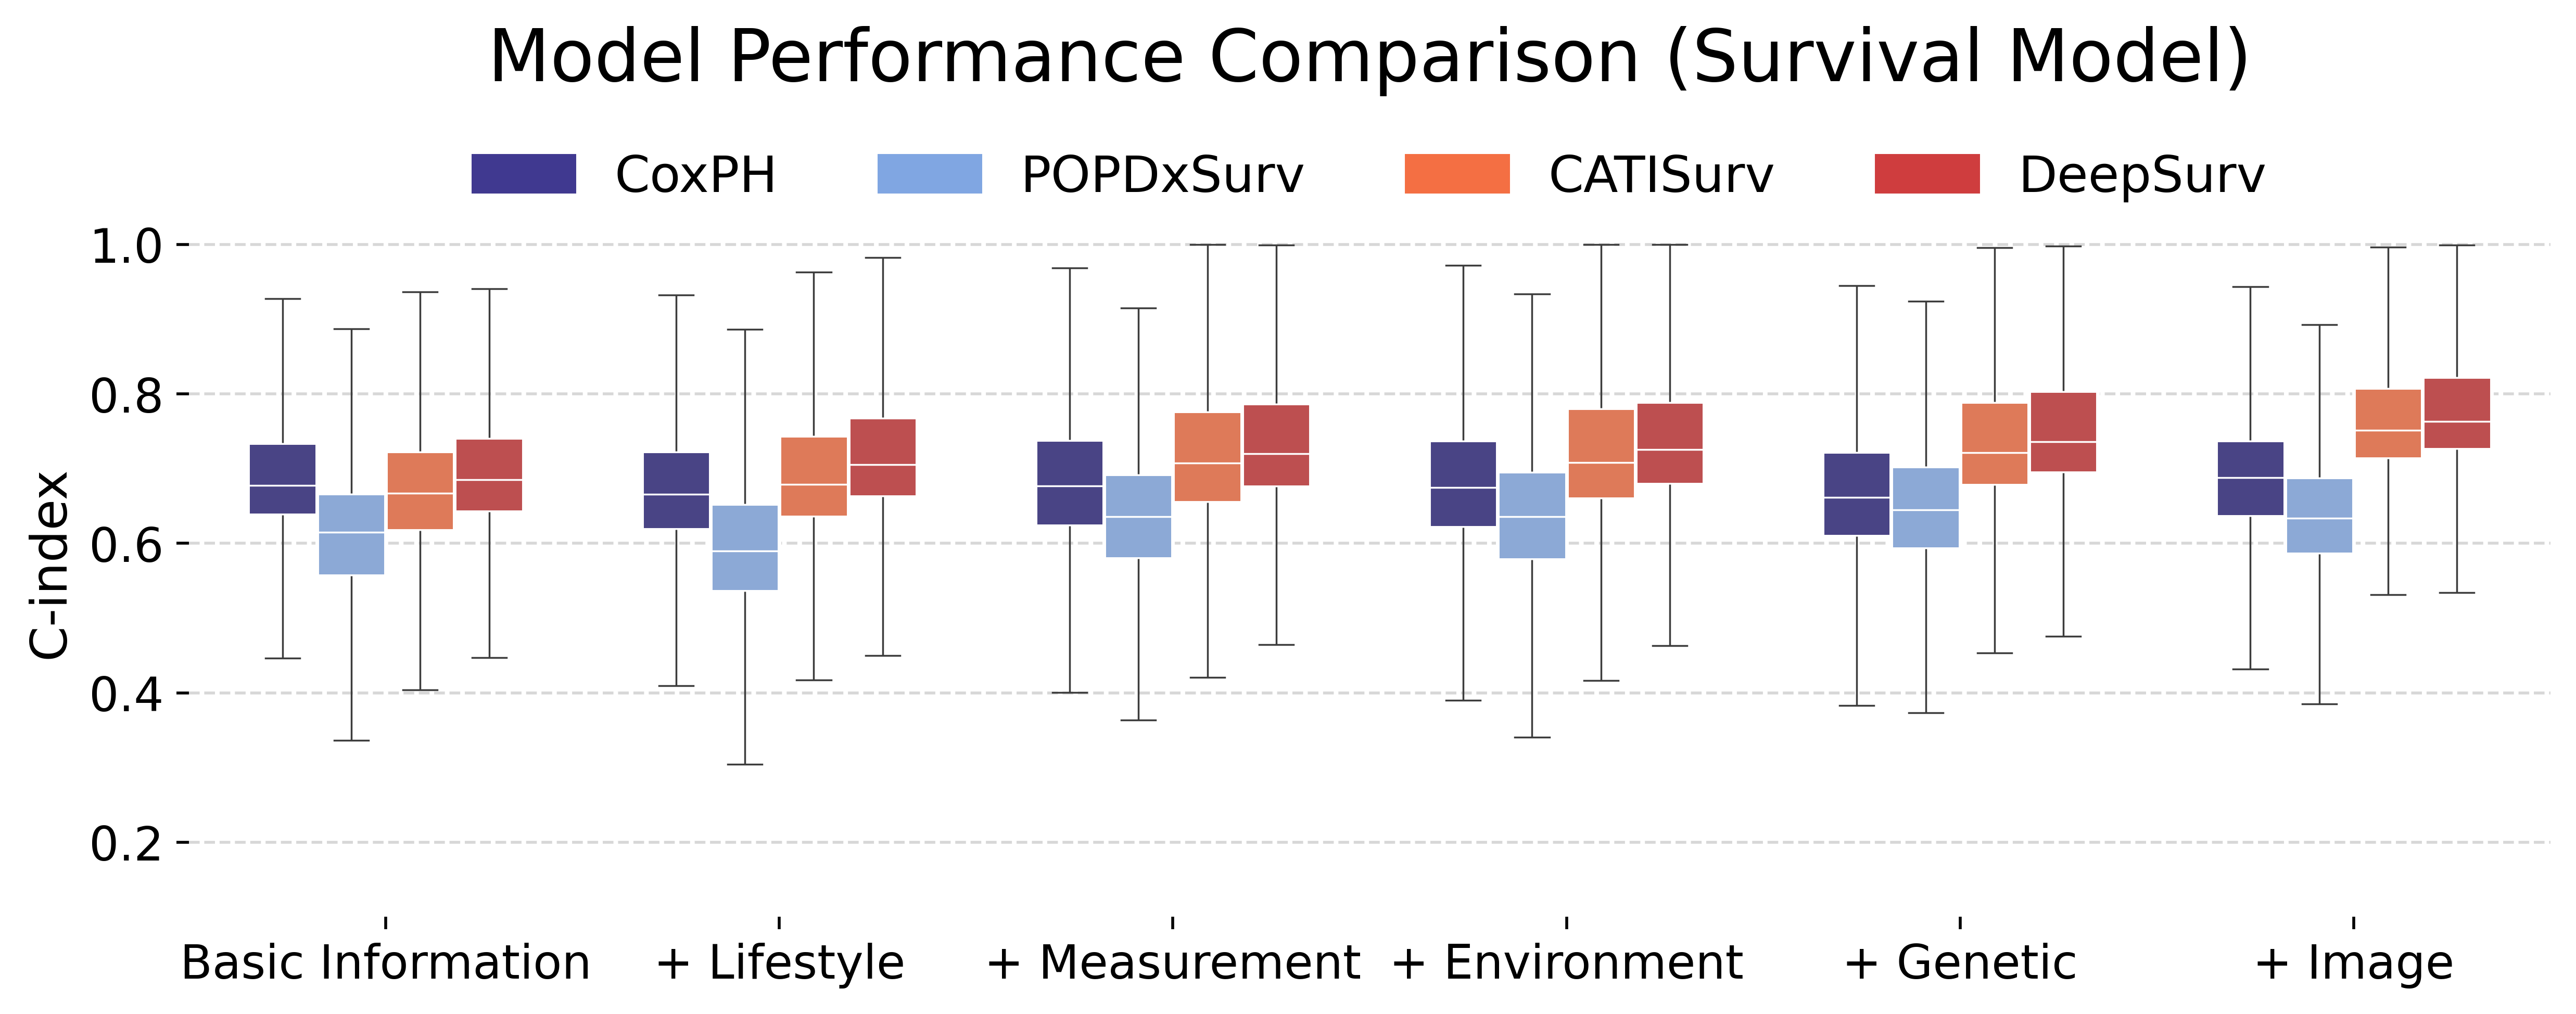

In [12]:
colors = ['#403990','#80A6E2','#F46F43','#CF3D3E']
cm = LinearSegmentedColormap.from_list('Nature', colors, N=4)
colorlist = []
for i in range(4):
    colorlist.append(cm(i))
color_palette = sns.color_palette(colorlist)
plt.figure(dpi=500, figsize=(10,4))
# plt.locator_params(axis='y', nbins=11)
plt.grid(True,linestyle='--',alpha=0.5)
ax=sns.boxplot(y='data',x='hue',hue='group',palette=color_palette,data=ipt, whis=2, fliersize=0, notch=False,
            showfliers=True, width = 0.7, boxprops={'linewidth': 1, 'linestyle':"-", 'edgecolor':'white'}, whiskerprops={'linestyle': '-', 'linewidth': 0.5},
            capprops={'linewidth': 0.5}, medianprops={'linewidth': 0.5, 'color':'white'}, gap=0)
names=['Basic Information','+ Lifestyle','+ Measurement','+ Environment','+ Genetic', '+ Image']
plt.xticks(np.arange(len(names)), names, fontsize=13,rotation=0)
plt.yticks(fontsize=13)
legend_names=['CoxPH','POPDxSurv','CATISurv','DeepSurv']
legend_handles=[]
for i in range(4):
    legend_handles.append(Patch(color=colorlist[i], label=legend_names[i]))
legend = plt.legend(handles=legend_handles, ncol=4,fontsize=14,loc='upper center',bbox_to_anchor=(0.5, 1.14))
legend.get_frame().set_linewidth(0)
legend.get_frame().set_facecolor('none') 
plt.ylim(0.1,1.05)
plt.xlabel("")
plt.ylabel("C-index", fontsize=14)
title = 'Model Performance Comparison (Survival Model)'
plt.title(title, pad=35, fontsize=20)
plt.tight_layout()
ax = plt.gca()
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.spines['left'].set_color('none')
ax.spines['right'].set_color('none')
plt.savefig(temppath+title+'.pdf', format='pdf',bbox_inches="tight")
plt.show()

In [13]:
d = ipt.groupby(['hue','group']).median('data').data.to_numpy()
m = {}
for i, name in enumerate(names):
    m[name] = list(d[(i*4):(i*4+4)])
json_file_path = numericpath + title + '.json'
with open(json_file_path, 'w', encoding='utf-8') as f:
    json.dump(m, f, ensure_ascii=False, indent=4)

In [14]:
lab=np.load(f'{survpath}/0lab.npy')[1]
totalpos=[]
for i in range(1560):
    totalpos.append(np.nansum(lab[:,i]))
    print(np.nansum(lab[:,i]))
sec=[-1,200,500000]
countcat=[]
for i in totalpos:
    for j in range(len(sec)-1):
        if sec[j]<=i<sec[j+1]:
            countcat.append(j)
seqdata=[]
seqgroup=[]
seqhue=[]
for i in range(4):
    t='6'+str(i)
    fd=np.array(cat5data[t])
    for j in range(len(np.array(cat5data[t]))):
        seqdata.append(fd[j])
        seqgroup.append(countcat[j])
        seqhue.append(i)
iptsec5=pd.DataFrame({'group':seqgroup,'hue':seqhue,'data':seqdata})
iptsec5

2061.0
330.0
55.0
247.0
386.0
13.0
3211.0
5.0
0.0
1325.0
304.0
128.0
1124.0
558.0
410.0
3.0
810.0
931.0
83.0
623.0
22.0
8.0
28.0
21.0
1.0
617.0
927.0
31.0
15.0
27.0
1.0
1637.0
728.0
312.0
225.0
296.0
1193.0
88.0
44.0
1.0
1.0
0.0
37.0
22.0
14.0
8.0
93.0
1.0
13.0
44.0
74.0
1094.0
29.0
13.0
52.0
19.0
7.0
4.0
10.0
54.0
6.0
11.0
37.0
6.0
174.0
126.0
6.0
583.0
367.0
72.0
55.0
190.0
206.0
923.0
28.0
47.0
39.0
12.0
97.0
573.0
15.0
46.0
509.0
2251.0
216.0
11.0
249.0
1142.0
7.0
21.0
98.0
190.0
10.0
37.0
143.0
38.0
1262.0
67.0
20.0
14.0
5.0
478.0
192.0
13.0
120.0
361.0
30.0
21.0
44.0
9.0
103.0
57.0
15.0
90.0
3586.0
13.0
310.0
1074.0
632.0
407.0
673.0
184.0
590.0
46.0
338.0
191.0
30.0
34.0
240.0
227.0
48.0
115.0
84.0
16.0
8.0
98.0
8.0
48.0
15.0
10.0
570.0
4340.0
103.0
1278.0
51.0
38.0
492.0
357.0
130.0
1434.0
149.0
638.0
20.0
148.0
16.0
408.0
35.0
11.0
57.0
0.0
151.0
9.0
22.0
1.0
58.0
82.0
60.0
317.0
30.0
1.0
136.0
16.0
141.0
150.0
407.0
105.0
40.0
20.0
457.0
287.0
2046.0
47.0
18.0
0.0
39.0
340.0


,group,hue,data
0,1,0,0.684517
1,1,0,0.642601
2,0,0,0.635143
3,1,0,0.699817
4,1,0,0.673613
...,...,...,...
6235,0,3,0.664185
6236,0,3,0.821609
6237,0,3,0.754909
6238,1,3,0.722559


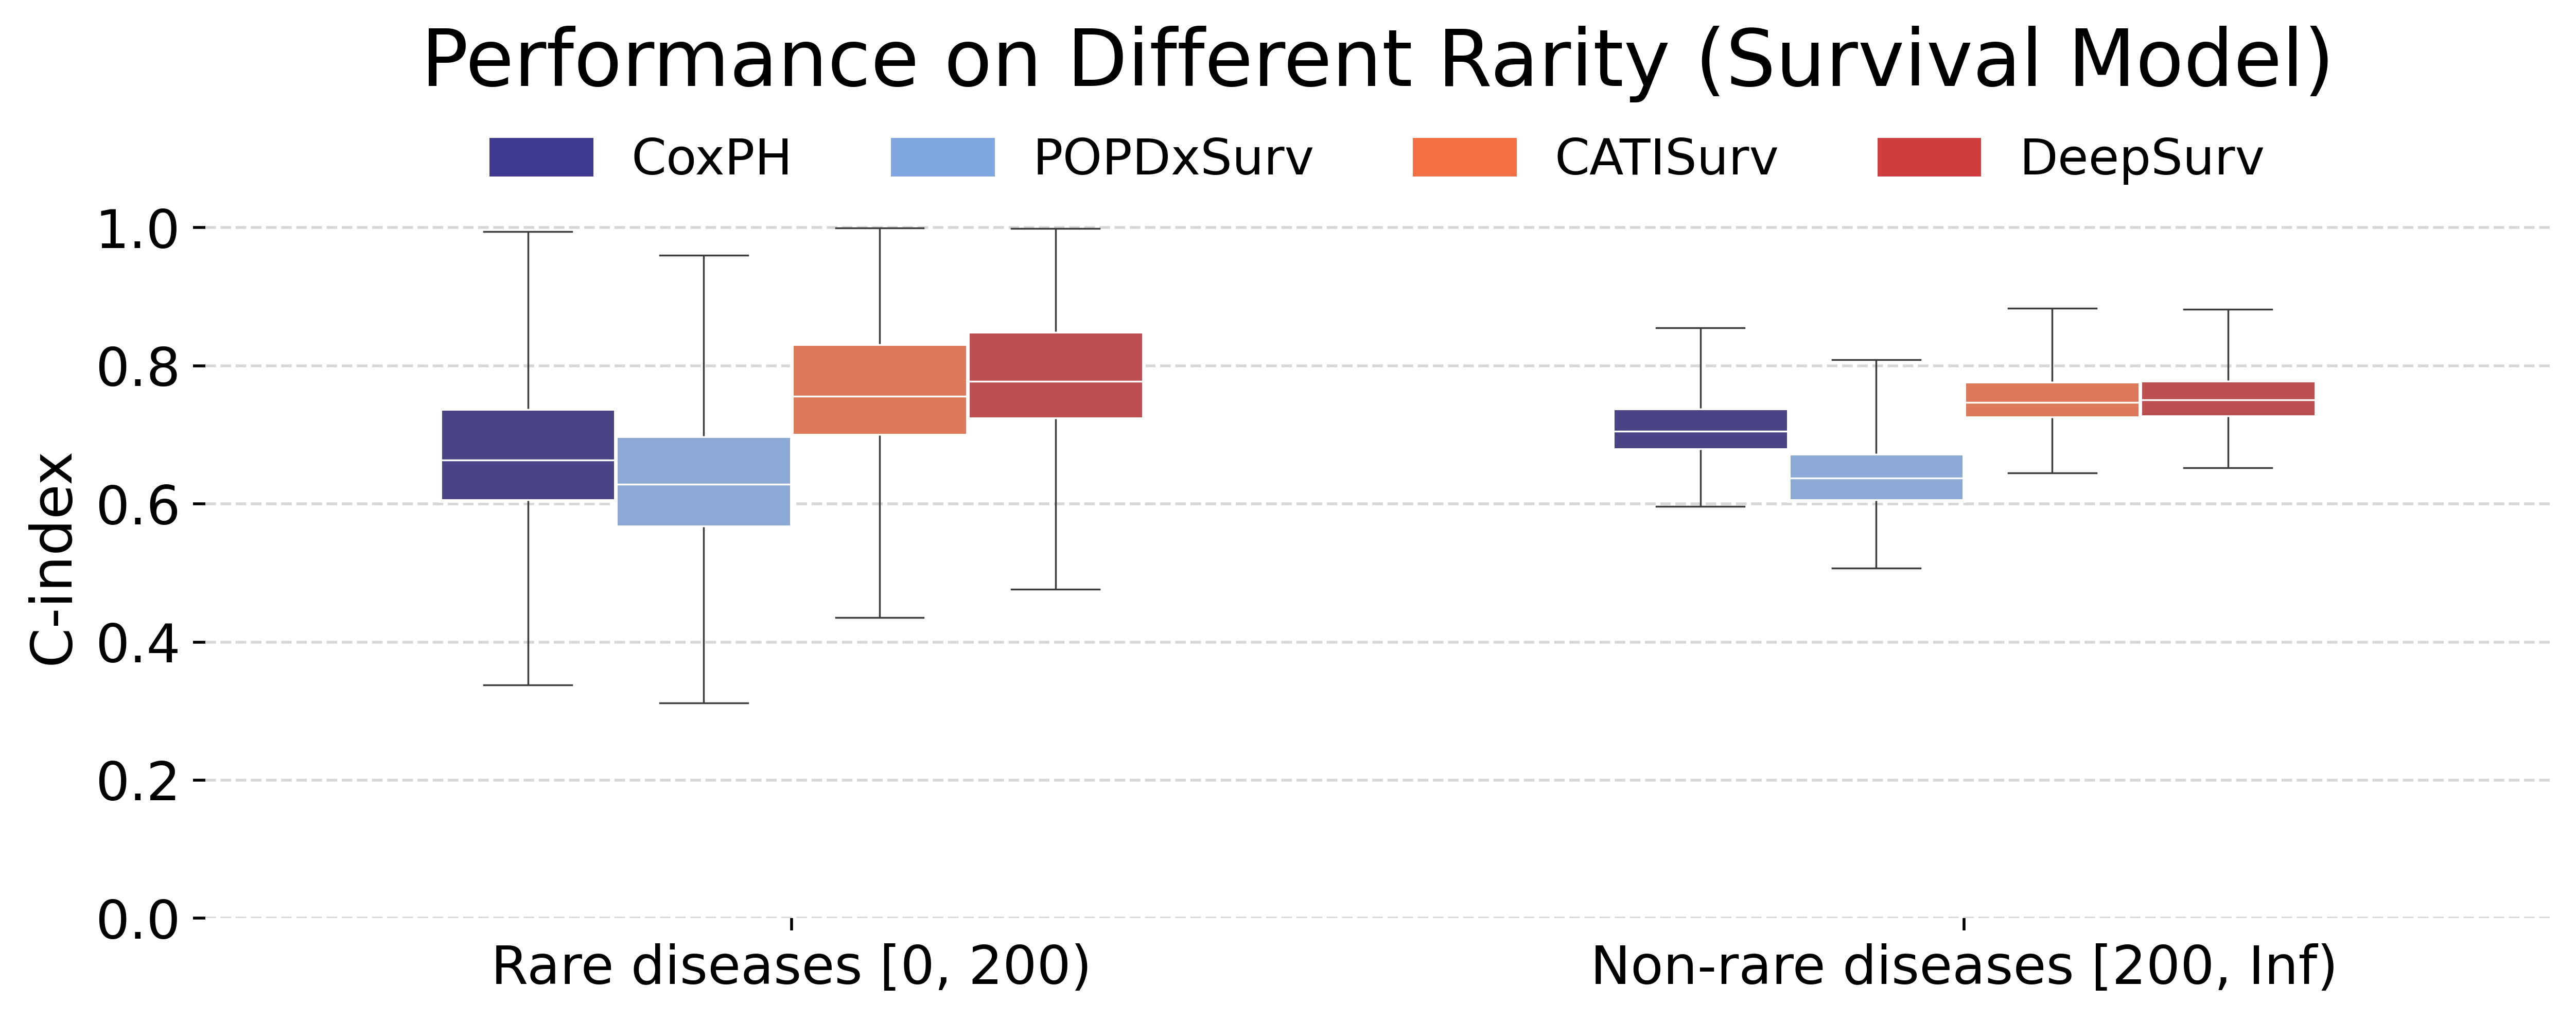

In [15]:
colors = ['#403990','#80A6E2','#F46F43','#CF3D3E']
cm = LinearSegmentedColormap.from_list('Nature', colors, N=4)
colorlist = []
for i in range(4):
    colorlist.append(cm(i))
color_palette = sns.color_palette(colorlist)
plt.figure(dpi=500, figsize=(10,4))
plt.grid(True,linestyle='--',alpha=0.5)
ax=sns.boxplot(y='data',x='group',hue='hue',palette=color_palette,data=iptsec5, whis=2, fliersize=0, notch=False,
            showfliers=True, width = 0.6, boxprops={'linewidth': 1, 'linestyle':"-", 'edgecolor':'white'}, whiskerprops={'linestyle': '-', 'linewidth': 0.5},
            capprops={'linewidth': 0.5}, medianprops={'linewidth': 0.5, 'color':'white'}, gap=0)
title='Performance on Different Rarity (Survival Model)'
plt.title(title, pad=30, fontsize=22)
legend_names=['CoxPH','POPDxSurv','CATISurv','DeepSurv']
legend_handles=[]
for i in range(4):
    legend_handles.append(Patch(color=colorlist[i], label=legend_names[i]))
legend = plt.legend(handles=legend_handles, ncol=4,fontsize=14,loc='upper center',bbox_to_anchor=(0.5, 1.14))
legend.get_frame().set_linewidth(0)
legend.get_frame().set_facecolor('none') 
plt.ylim(0,1.05)
plt.xlabel("")
plt.ylabel("C-index", fontsize=16)
plt.tight_layout()
ax = plt.gca()
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.spines['left'].set_color('none')
ax.spines['right'].set_color('none')
names=['Rare diseases [0, 200)','Non-rare diseases [200, Inf)',]
plt.xticks(np.arange(len(names)), names, fontsize=15,rotation=0)
plt.yticks(fontsize=15)
plt.savefig(temppath + title + '.pdf', format='pdf',bbox_inches="tight")
plt.show()

In [16]:
d = iptsec5.groupby(['group','hue']).median().data.to_numpy()
m = {}
for i, name in enumerate(names):
    m[name] = list(d[(i*4):(i*4+4)])
json_file_path = numericpath + title + '.json'
with open(json_file_path, 'w', encoding='utf-8') as f:
    json.dump(m, f, ensure_ascii=False, indent=4)